In [1]:
from google.colab import drive
drive.mount('/content/drive')

import numpy as np

path = "/content/drive/MyDrive/ColabNotebooks/MachineLearningCoursework/" # Change path to run program
train_x = np.load(path + "train_x.npy", allow_pickle=True)
train_y = np.load(path + "train_y.npy", allow_pickle=True)
test_x = np.load(path + "test_x.npy", allow_pickle=True)
test_y = np.load(path + "test_y.npy", allow_pickle=True)
valid_x = np.load(path + "valid_x.npy", allow_pickle=True)
valid_y = np.load(path + "valid_y.npy", allow_pickle=True)

Mounted at /content/drive


In [2]:
# Code used from view.ipynb provided
import matplotlib.pyplot as plt

def image_normalization(arr):
    return (arr - arr.min())/(arr.max()-arr.min())

def disable_ax_ticks(ax):
    ax.set_xticks([])
    ax.set_xticks([], minor=True)
    ax.set_yticks([])
    ax.set_yticks([], minor=True)

def show_mnist_examples(x, y):
    fig = plt.figure(constrained_layout=True,figsize=(12,9), dpi=100)
    gs = fig.add_gridspec(3,4)
    main_ax = fig.add_subplot(gs[:3,:3])
    fig.suptitle(y)
    main_ax.imshow(image_normalization(np.moveaxis(x, 0, -1)))
    disable_ax_ticks(main_ax)

    for j in range(3):
      c_ax = fig.add_subplot(gs[j,-1])
      subimage = x.copy()
      subimage[:j] = 0
      subimage[j+1:] = 0
      subimage[j] = subimage[j]-subimage[j].min()
      c_ax.imshow(image_normalization(np.moveaxis(subimage, 0, -1)))
      disable_ax_ticks(c_ax)
    plt.show()

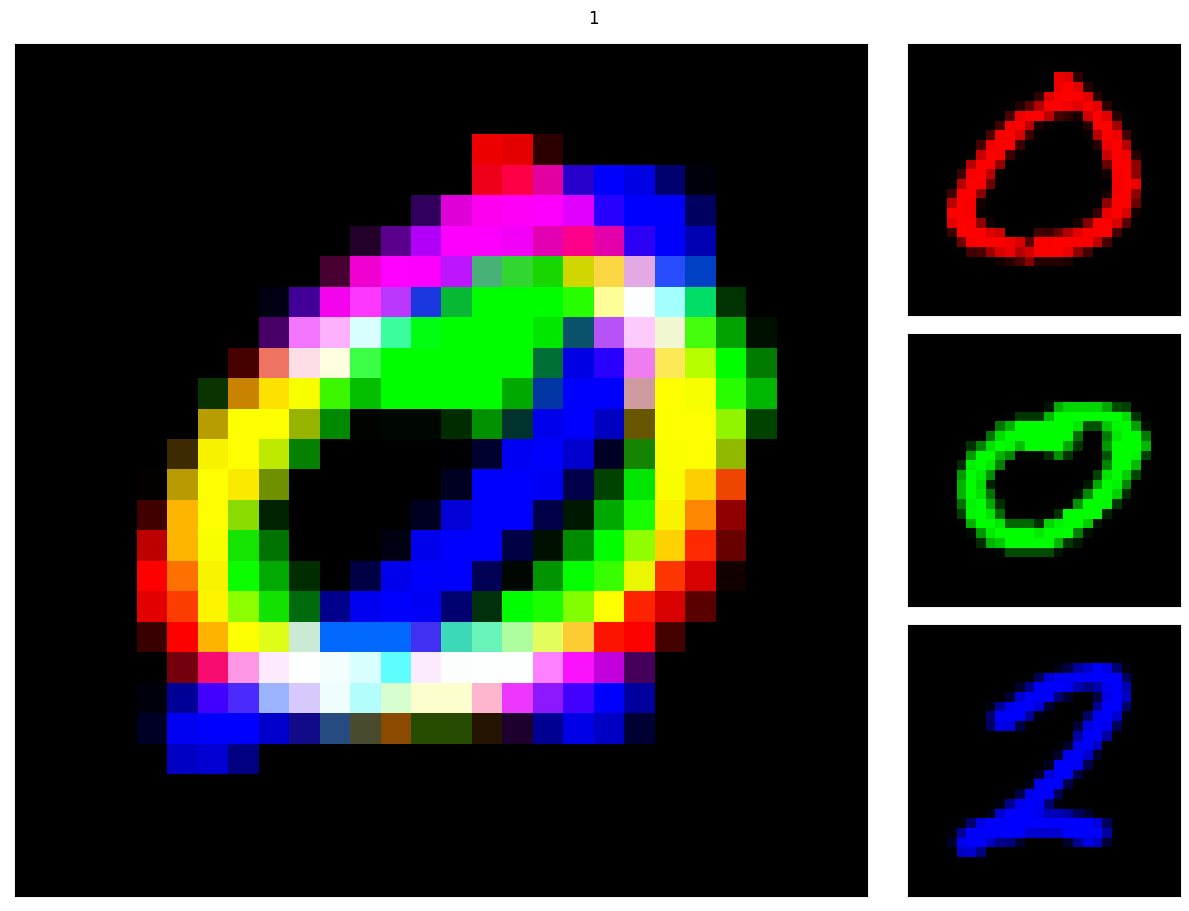

In [3]:
import random

# Display random image from training dataset
ri = random.randrange(train_x.shape[0])
show_mnist_examples(train_x[ri], train_y[ri])

# Reshape train, test and validate datasets to be channel last for the model
train_x = train_x.reshape(train_x.shape[0], 28, 28, 3)
test_x = test_x.reshape(test_x.shape[0], 28, 28, 3)
valid_x = valid_x.reshape(valid_x.shape[0], 28, 28, 3)

train_x = image_normalization(train_x)
test_x = image_normalization(test_x)
valid_x = image_normalization(valid_x)

In [4]:
from tensorflow.keras.applications import VGG16

# Set VGG16 as the base model with include_top=False to disclude the top layers of the model
base_model = VGG16(weights="imagenet", input_shape=(224, 224, 3), include_top=False)
# Freeze the weights of the base model
base_model.trainable = False

58889256/58889256 [==============================] - 3s 0us/step


In [5]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

This model took the largest amount of time to get right, a lot of research into which layers should be used was conducted. Many examples found used very aggressive dropout values, but it was found that a lower value worked better for this model through testing. Different layouts for the dense layers were tested until layers that worked well with the pre-trained model were found. Batch normalisation layers between each of the dense layers helped with this as well.

In [6]:
from tensorflow.keras import layers, models
import tensorflow as tf

# Resolution to reshape images to
new_res = (224, 224)

# Defining the model with the base_model included
model = models.Sequential([
  layers.InputLayer(train_x[0].shape),
  # Resize images to fit model
  layers.Lambda(lambda image: tf.image.resize(image, new_res)),
  base_model,
  # Flatten the output of the base model into one dimension
  layers.Flatten(),
  layers.BatchNormalization(),
  # First dense layer
  layers.Dense(1024, activation='relu'),
  layers.BatchNormalization(),
  # Second dense layer
  layers.Dense(512, activation='relu'),
  layers.BatchNormalization(),
  # Third dense layer
  layers.Dense(256, activation='relu'),
  layers.BatchNormalization(),
  # Fourth dense layer
  layers.Dense(128, activation='relu'),
  layers.BatchNormalization(),
  # Fifth dense layer
  layers.Dense(64, activation='relu'),
  # Dropout layer to reduce overfitting
  layers.Dropout(0.1),
  layers.BatchNormalization(),
  # Final dense layer for prediction
  layers.Dense(20, activation='softmax')                  
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, 224, 224, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 batch_normalization (BatchN  (None, 25088)            100352    
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 1024)              25691136  
                                                                 
 batch_normalization_1 (Batc  (None, 1024)             4096      
 hNormalization)                                        

50 epochs was chosen to stop the model from training for too long if early stopping hadn't stopped it by 50 epochs. Different learning rates were tested for this model, but the default learning rate of 0.001 for Adam ended up giving the best results.

In [8]:
from tensorflow.keras.callbacks import EarlyStopping

# Compile, fit and evaluate model
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'],
)

# Stops model fitting if the accuracy of 3 epochs in a row is below the maximum
# accuracy achieved on a previous epoch
es = EarlyStopping(monitor='val_accuracy', mode='max', patience=3, restore_best_weights=True)

model_output = model.fit(x=train_x, y=train_y, epochs=50, validation_data=(valid_x, valid_y), callbacks=[es])
model.evaluate(test_x, test_y)

Epoch 1/50
1407/1407 [==============================] - 301s 213ms/step - loss: 2.1496 - accuracy: 0.2684 - val_loss: 1.6938 - val_accuracy: 0.3910
Epoch 2/50
1407/1407 [==============================] - 298s 212ms/step - loss: 1.6093 - accuracy: 0.4427 - val_loss: 1.3030 - val_accuracy: 0.5626
Epoch 3/50
1407/1407 [==============================] - 298s 212ms/step - loss: 1.1970 - accuracy: 0.6025 - val_loss: 0.9542 - val_accuracy: 0.6950
Epoch 4/50
1407/1407 [==============================] - 298s 212ms/step - loss: 0.8516 - accuracy: 0.7254 - val_loss: 0.7727 - val_accuracy: 0.7678
Epoch 5/50
1407/1407 [==============================] - 298s 212ms/step - loss: 0.6087 - accuracy: 0.8090 - val_loss: 0.7032 - val_accuracy: 0.7939
Epoch 6/50
1407/1407 [==============================] - 298s 212ms/step - loss: 0.4679 - accuracy: 0.8523 - val_loss: 0.6727 - val_accuracy: 0.8087
Epoch 7/50
1407/1407 [==============================] - 298s 211ms/step - loss: 0.3725 - accuracy: 0.8820 - val_

[0.6834878921508789, 0.859499990940094]

In [ ]:
import matplotlib.pyplot as plt

acc = model_output.history['accuracy']
val_acc = model_output.history['val_accuracy']
loss = model_output.history['loss']
val_loss = model_output.history['val_loss']

epochs = range(len(acc))

# Displays a plot of the training accuracy and validation accuracy over each epoch
plt.plot(epochs, acc, 'bo--', label='Training acc')
plt.plot(epochs, val_acc, 'ro--', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

# Displays a plot of the training loss and validation loss over each epoch
plt.plot(epochs, loss, 'bo--', label='Training loss')
plt.plot(epochs, val_loss, 'ro--', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()